In [182]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

import time
from PIL import Image

from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

to_pil_image = T.ToPILImage()

GPU not available, CPU used


In [228]:
mnist_train = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=T.Compose([T.Resize(32), T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))])
)

In [229]:
svhn_train = datasets.SVHN(
    root='data',
    download=True,
    transform=T.Compose([ T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))])
)

Using downloaded and verified file: data/train_32x32.mat


# VAE

In [271]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size = 300, latent_size = 100):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 2 * latent_size)
        )
    
    def sample(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + sigma * eps
        
    def forward(self, x):
        h = self.encoder(x)

        mu, log_var = torch.chunk(h, 2, dim=1)
        sigma = torch.exp(0.5*log_var) 
        z = self.sample(mu, sigma)
        
        return z, mu, sigma

class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size = 300, latent_size = 100):
        super(Decoder, self).__init__()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decoder(x) 
    
class GaussianPrior(nn.Module):
    def __init__(self, latent_size=100):
        super(GaussianPrior, self).__init__()
        self.latent_size = latent_size

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.latent_size))
        return z

    def log_prob(self, z):
        PI = torch.from_numpy(np.asarray(np.pi)).to(device)
        return -0.5 * torch.log(2. * PI) - 0.5 * z**2.
                

class VAE(nn.Module):
    def __init__(self, input_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size)
        self.decoder = Decoder(input_size)
        
    def forward(self, x):
        z, mu, sigma = self.encoder(x)
                
        return self.decoder(z), z, mu, sigma
    
    
class ELBO():
    def __init__(self, prior):
        self.prior = prior
        self.reconstruction_error = nn.BCELoss(reduction='none')
    
    def kullback_Leibler_divergence(self, z, mu, sigma):
        q = torch.distributions.Normal(mu, sigma)

        log_qz = q.log_prob(z)
        log_pz = self.prior.log_prob(z)
        
        kl = (log_qz - log_pz).sum(-1)
        
        return kl
    
    def __call__(self, inputs, outputs, z, mu, sigma):
        
        re = self.reconstruction_error(outputs, inputs).sum(-1)
        kl = self.kullback_Leibler_divergence(z, mu, sigma)

        elbo = re + kl
        return elbo.mean()

In [284]:

def train(net, prior, train_data, val_data, img_dim, batch_size=10, learning_rate=0.0001, epochs=20, nr_test_samples=64):
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    criterion = ELBO(prior)
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

    running_loss = []
    running_val_loss = []

    for epoch in range(epochs):
        print("Epoch:" , epoch+1)

        for i, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
            optimizer.zero_grad()

            inputs, _ = data
            inputs = inputs.to(device)

            # Forward
            outputs, z, mu, sigma = net(inputs)
            
            # Backward
            loss = criterion(inputs, outputs, z, mu, sigma)
            loss.backward()
            optimizer.step()
            
            running_loss.append(loss.item())
            
        sample = prior.sample(nr_test_samples)
        generated_img = net.decoder(sample).view(nr_test_samples,img_dim,32,32)
        generated_img = make_grid(generated_img)
    
        #SAVE IMAGE
        im = Image.fromarray(np.array(to_pil_image(generated_img)))
        im.save(f"Images_output/vae/epoch_{epoch}.jpeg")
        
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(device)  
                outputs, z, mu, sigma  = net(inputs)
                loss = criterion(inputs, outputs, z, mu, sigma)
                running_val_loss.append(loss)
                
        print(f'Train Loss: {np.mean(running_loss[-len(train_data):])} | Validation Loss: {np.mean(running_val_loss[-len(val_data):])}')
    
    return running_loss, running_val_loss




In [285]:
net = VAE(input_size).to(device)
prior = GaussianPrior()
train_set, val_set = torch.utils.data.random_split(mnist_train, [55000, 5000])
train_loss, val_loss = train(net, prior, train_set, val_set, 1, batch_size=25, epochs=50)


  0%|          | 8/2200 [00:00<00:29, 74.69it/s]

Epoch: 1


  0%|          | 10/2200 [00:00<00:23, 94.05it/s]

Train Loss: 270.1516437738592 | Validation Loss: 244.1982879638672
Epoch: 2


  0%|          | 10/2200 [00:00<00:23, 93.15it/s]

Train Loss: 250.32230444474655 | Validation Loss: 229.11285400390625
Epoch: 3


  0%|          | 10/2200 [00:00<00:23, 93.22it/s]

Train Loss: 235.89736766699588 | Validation Loss: 219.27517700195312
Epoch: 4


  0%|          | 10/2200 [00:00<00:23, 91.96it/s]

Train Loss: 225.69415427814832 | Validation Loss: 211.9357452392578
Epoch: 5


  0%|          | 10/2200 [00:00<00:23, 93.22it/s]

Train Loss: 217.83210822226783 | Validation Loss: 205.9114990234375
Epoch: 6


  0%|          | 10/2200 [00:00<00:23, 92.96it/s]

Train Loss: 211.30397053920862 | Validation Loss: 200.8014678955078
Epoch: 7


  0%|          | 9/2200 [00:00<00:25, 86.90it/s]

Train Loss: 205.80110804966517 | Validation Loss: 196.41043090820312
Epoch: 8


  0%|          | 10/2200 [00:00<00:24, 90.53it/s]

Train Loss: 201.14117405718022 | Validation Loss: 192.65402221679688
Epoch: 9


  0%|          | 8/2200 [00:00<00:29, 74.63it/s]

Train Loss: 197.15926374262028 | Validation Loss: 189.40977478027344
Epoch: 10


  0%|          | 9/2200 [00:00<00:24, 89.95it/s]

Train Loss: 193.719923278115 | Validation Loss: 186.6671905517578
Epoch: 11


  0%|          | 10/2200 [00:00<00:23, 92.21it/s]

Train Loss: 190.72141235225456 | Validation Loss: 184.21377563476562
Epoch: 12


  0%|          | 10/2200 [00:00<00:23, 91.42it/s]

Train Loss: 188.09274291703196 | Validation Loss: 182.0551300048828
Epoch: 13


  0%|          | 9/2200 [00:00<00:24, 89.57it/s]

Train Loss: 185.76897087737396 | Validation Loss: 180.16346740722656
Epoch: 14


  0%|          | 10/2200 [00:00<00:23, 91.80it/s]

Train Loss: 183.70169042512967 | Validation Loss: 178.46298217773438
Epoch: 15


  0%|          | 10/2200 [00:00<00:24, 91.21it/s]

Train Loss: 181.84781416621354 | Validation Loss: 176.941650390625
Epoch: 16


  0%|          | 10/2200 [00:00<00:23, 92.45it/s]

Train Loss: 180.17809626882726 | Validation Loss: 175.54234313964844
Epoch: 17


  0%|          | 10/2200 [00:00<00:24, 90.90it/s]

Train Loss: 178.66833701291824 | Validation Loss: 174.29078674316406
Epoch: 18


  0%|          | 10/2200 [00:00<00:23, 92.06it/s]

Train Loss: 177.29334151624428 | Validation Loss: 173.13812255859375
Epoch: 19


  0%|          | 10/2200 [00:00<00:23, 91.85it/s]

Train Loss: 176.03764746871292 | Validation Loss: 172.08387756347656
Epoch: 20


  0%|          | 10/2200 [00:00<00:23, 91.80it/s]

Train Loss: 174.8854922698628 | Validation Loss: 171.11239624023438
Epoch: 21


  0%|          | 10/2200 [00:00<00:23, 91.41it/s]

Train Loss: 173.82202372018392 | Validation Loss: 170.22157287597656
Epoch: 22


  0%|          | 10/2200 [00:00<00:23, 91.77it/s]

Train Loss: 172.8361490520761 | Validation Loss: 169.39358520507812
Epoch: 23


  0%|          | 10/2200 [00:00<00:23, 92.66it/s]

Train Loss: 171.92219300522635 | Validation Loss: 168.63894653320312
Epoch: 24


  0%|          | 10/2200 [00:00<00:24, 91.12it/s]

Train Loss: 171.0699568569299 | Validation Loss: 167.92291259765625
Epoch: 25


  0%|          | 10/2200 [00:00<00:23, 91.38it/s]

Train Loss: 170.27308333823464 | Validation Loss: 167.2489776611328
Epoch: 26


  0%|          | 10/2200 [00:00<00:23, 91.92it/s]

Train Loss: 165.50013502641158 | Validation Loss: 163.51144409179688
Epoch: 27


  0%|          | 10/2200 [00:00<00:23, 92.31it/s]

Train Loss: 162.30464344843085 | Validation Loss: 160.9781036376953
Epoch: 28


  0%|          | 10/2200 [00:00<00:24, 91.19it/s]

Train Loss: 160.03585266085537 | Validation Loss: 159.0105438232422
Epoch: 29


  0%|          | 10/2200 [00:00<00:23, 93.01it/s]

Train Loss: 158.23639180394952 | Validation Loss: 157.42616271972656
Epoch: 30


  0%|          | 10/2200 [00:00<00:23, 91.31it/s]

Train Loss: 156.77592800889448 | Validation Loss: 156.1508331298828
Epoch: 31


  0%|          | 10/2200 [00:00<00:23, 91.84it/s]

Train Loss: 155.61682414994672 | Validation Loss: 155.13632202148438
Epoch: 32


  0%|          | 10/2200 [00:00<00:24, 91.09it/s]

Train Loss: 154.6845383367365 | Validation Loss: 154.3175048828125
Epoch: 33


  0%|          | 9/2200 [00:00<00:24, 88.18it/s]

Train Loss: 153.9156607685436 | Validation Loss: 153.6367950439453
Epoch: 34


  0%|          | 10/2200 [00:00<00:24, 90.75it/s]

Train Loss: 153.26744490966797 | Validation Loss: 153.06959533691406
Epoch: 35


  0%|          | 10/2200 [00:00<00:23, 91.44it/s]

Train Loss: 152.71447335579612 | Validation Loss: 152.55287170410156
Epoch: 36


  0%|          | 10/2200 [00:00<00:23, 92.51it/s]

Train Loss: 152.23606629264137 | Validation Loss: 152.13284301757812
Epoch: 37


  0%|          | 10/2200 [00:00<00:23, 91.81it/s]

Train Loss: 151.81277899780272 | Validation Loss: 151.75633239746094
Epoch: 38


  0%|          | 10/2200 [00:00<00:23, 91.40it/s]

Train Loss: 151.43579363791727 | Validation Loss: 151.40078735351562
Epoch: 39


  0%|          | 10/2200 [00:00<00:23, 93.15it/s]

Train Loss: 151.09622129974366 | Validation Loss: 151.09268188476562
Epoch: 40


  0%|          | 10/2200 [00:00<00:23, 92.74it/s]

Train Loss: 150.78847610265558 | Validation Loss: 150.80178833007812
Epoch: 41


  0%|          | 9/2200 [00:00<00:24, 88.91it/s]

Train Loss: 150.50487543182373 | Validation Loss: 150.54879760742188
Epoch: 42


  0%|          | 10/2200 [00:00<00:23, 92.55it/s]

Train Loss: 150.24245757224344 | Validation Loss: 150.3014373779297
Epoch: 43


  0%|          | 10/2200 [00:00<00:23, 93.02it/s]

Train Loss: 149.99913449804131 | Validation Loss: 150.0843505859375
Epoch: 44


  0%|          | 10/2200 [00:00<00:23, 92.83it/s]

Train Loss: 149.76888604902788 | Validation Loss: 149.87442016601562
Epoch: 45


  0%|          | 10/2200 [00:00<00:23, 92.54it/s]

Train Loss: 149.5534232788086 | Validation Loss: 149.67514038085938
Epoch: 46


  0%|          | 10/2200 [00:00<00:23, 93.44it/s]

Train Loss: 149.34999672033138 | Validation Loss: 149.4891815185547
Epoch: 47


  0%|          | 10/2200 [00:00<00:23, 92.06it/s]

Train Loss: 149.1603547103882 | Validation Loss: 149.3135986328125
Epoch: 48


  0%|          | 10/2200 [00:00<00:23, 92.75it/s]

Train Loss: 148.9787090660789 | Validation Loss: 149.13189697265625
Epoch: 49


  0%|          | 10/2200 [00:00<00:23, 93.20it/s]

Train Loss: 148.80677926316696 | Validation Loss: 148.97625732421875
Epoch: 50


100%|██████████| 2200/2200 [00:23<00:00, 93.87it/s]


Train Loss: 148.6439887656472 | Validation Loss: 148.82684326171875


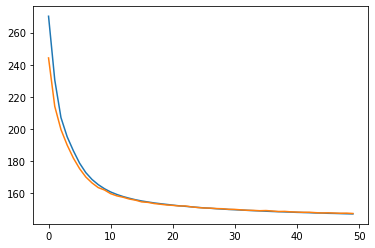

In [301]:
train_loss_epoch = np.array(train_loss).reshape(-1, int(55000/25)).mean(axis=1)
val_loss_epoch = np.array(val_loss).reshape(-1, int(5000/25)).mean(axis=1)

plt.plot(train_loss_epoch)
plt.plot(val_loss_epoch)
plt.show()

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=100):
    w = 32
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = net.decoder(z)
            
            generated_img = net.decoder(sample).view(nr_test_samples,img_dim,32,32)
            
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

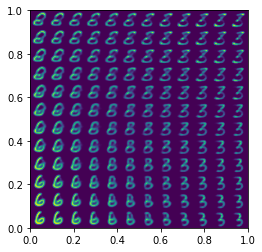

In [351]:
def plot_manifold_sample(net, img_dim, n=12):
    w = 32
    img = np.zeros((n*w, n*w))
    
    s, e1, e2 = prior.sample(3)
    
    for i, y in enumerate(np.linspace(0, 1, n)):
        for j, x in enumerate(np.linspace(0, 1, n)):
            
            z = s + (e1-s) * x + (e2-s) * y
            generated_image = net.decoder(z.view(-1,100)).view(1, 32,32)

            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = generated_image.detach().numpy()
    plt.imshow(img, extent=[0, 1, 0, 1])

plot_manifold_sample(net, 1)

# VAE with flow based prior

In [255]:

# From https://github.com/jmtomczak/intro_dgm/blob/main/vaes/vae_priors_example.ipynb

class FlowPrior(nn.Module):
    def __init__(self, nets, nett, num_flows, D=2):
        super(FlowPrior, self).__init__()

        self.D = D

        self.t = torch.nn.ModuleList([nett() for _ in range(num_flows)])
        self.s = torch.nn.ModuleList([nets() for _ in range(num_flows)])
        self.num_flows = num_flows

    def coupling(self, x, index, forward=True):
        (xa, xb) = torch.chunk(x, 2, 1)

        s = self.s[index](xa)
        t = self.t[index](xa)

        if forward:
            #yb = f^{-1}(x)
            yb = (xb - t) * torch.exp(-s)
        else:
            #xb = f(y)
            yb = torch.exp(s) * xb + t

        return torch.cat((xa, yb), 1), s

    def permute(self, x):
        return x.flip(1)

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in range(self.num_flows):
            z, s = self.coupling(z, i, forward=True)
            z = self.permute(z)
            log_det_J = log_det_J - s.sum(dim=1)

        return z, log_det_J

    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x, _ = self.coupling(x, i, forward=False)

        return x

    def sample(self, batch_size):
        z = torch.randn(batch_size, self.D)
        x = self.f_inv(z)
        return x.view(-1, self.D)

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        
        PI = torch.from_numpy(np.asarray(np.pi))
        log_standard_normal = -0.5 * torch.log(2. * PI) - 0.5 * z**2.
        
        log_p = (log_standard_normal + log_det_J.unsqueeze(1))
        return log_p

In [256]:
num_flows = 3
L = 100
M = 300

nets = lambda: nn.Sequential(nn.Linear(L // 2, M), nn.LeakyReLU(),
                            nn.Linear(M, M), nn.LeakyReLU(),
                            nn.Linear(M, L // 2), nn.Tanh())

nett = lambda: nn.Sequential(nn.Linear(L // 2, M), nn.LeakyReLU(),
                            nn.Linear(M, M), nn.LeakyReLU(),
                            nn.Linear(M, L // 2))

prior = FlowPrior(nets, nett, num_flows=num_flows, D=L)


input_size = train_data[0][0].shape[0]
batch_size = 10

net = VAE(input_size).to(device)

loss = train(net, prior, mnist_train, 1)



  0%|          | 7/6000 [00:00<01:31, 65.65it/s]

Epoch: 1


 80%|███████▉  | 4773/6000 [00:56<00:14, 84.84it/s]


KeyboardInterrupt: 

torch.Size([1, 1024])
